In [46]:
import json
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
from sklearn.metrics import mean_squared_error, mean_absolute_error

In [162]:
#Function to calculate RMSE
def rmse(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))

def mae(y_true, y_pred):
    return mean_absolute_error(y_true, y_pred)

def mape(y_true, y_pred):
    # Filter out positions where y_true is zero
    mask = y_true > 1
    y_true_filtered = y_true[mask]
    y_pred_filtered = y_pred[mask]
    
    # Calculate MAPE using filtered arrays
    return np.mean(np.abs((y_true_filtered - y_pred_filtered) / y_true_filtered)) * 100

In [163]:
def generate_month_forecast_figure_normalized(path, month_idx, save=False):
    observed = []
    predicted = []
    
    with open(path, 'r') as file:
        data = json.load(file)
        print(len(data['source_readings']))


        idx = 0
#         print(data['source_readings'][0])
        print(idx)
        while True:
#             try:
            source = data['source_readings'][min(idx+3, len(data['source_readings'])-1)]
#             print(len(source[0]))


            m = source[0][month_idx]
            if idx > len(data['source_readings'])-1:
                break
            expected_ex = data['expected'][idx]
#             print(expected_ex)
#             print(" ")
            
            predicted_ex = data['predicted'][idx]
#             print(predicted_ex)
#             print(" ")
            
            observed += expected_ex
            predicted += predicted_ex
            
            idx +=1
        predicted = np.array(predicted)
        observed= np.array(observed)
        for i in range(3):
            pred = predicted[:,i]
            obs= observed[:,i]
            print(pred.shape)
            plt.figure(figsize=(16, 6))  # Set the figure size for better visibility
            plt.plot(obs,linestyle='-', c='r', marker='.', linewidth=1, alpha=0.7, label="Observed")
            plt.plot(pred,linestyle='-', c='b', marker='.', linewidth=1, alpha=0.7, label="Model 24h Forecast")
    #         plt.title(f"C7 2023 Forecast Example for Month {actual_month}")
            plt.xlabel('Hour')
            plt.ylabel('Demand (Normalized)')
            plt.legend()
            if save:
                print("saving")
                print(path)
                code = path.split("/")[2].split("_")[0]
                plt.savefig(f"/Users/aidanwiteck/Desktop/Princeton/Year 4/Thesis/Homeworks/SpringInterimReport/{code}_{actual_month}_predictions.pdf", 
                            format="pdf", 
                            bbox_inches="tight")
                print("Saved")
            plt.show()

            model_rmse = rmse(pred, obs)
            model_mape = mape(pred, obs)

            print(f"Model RMSE: {model_rmse}")
            print(f"Model MAPE: {model_mape}")
            

In [166]:
def generate_unnormalized_errors(directory_path):
    observed = []
    predicted = []
    
    norms = {
      "wind": {
        "Coast": 489.515,
        "East": 541.2,
        "West": 7504.996,
        "Far_West": 8894.299,
        "North": 14930.786,
        "North_Central": 3928.436,
        "South": 10936.024,
        "South_Central": 976.235
      },
      "solar": {
        "Coast": 5575.983,
        "East": 1412.142,
        "West": 5055.946,
        "Far_West": 13002.247,
        "North": 6890.612,
        "North_Central": 4518.347,
        "South": 3480.534,
        "South_Central": 592.381
      },
      "load_mean": {
        "Coast": 11846.571,
        "East": 1610.689,
        "West": 1348.556,
        "Far_West": 2584.998,
        "North": 1020.2,
        "North_Central": 13235.539,
        "South": 3475.807,
        "South_Central": 6790.667
      },
      "load_std": {
        "Coast": 2628.505,
        "East": 380.432,
        "West": 267.07,
        "Far_West": 382.347,
        "North": 219.958,
        "North_Central": 3566.134,
        "South": 837.194,
        "South_Central": 1802.092
      }
    }

    models = 'ABCDEF'
    for letter in models:        
        observed = np.empty((0, 3))
        predicted = np.empty((0, 3))
        
        all_files = [f for f in os.listdir(directory_path) if f.endswith(".json")]
        for filename in all_files:
            if filename.split('_')[2] == letter:
                parts = filename.split('_')
                region = '_'.join(parts[4:-2])
                with open(os.path.join(directory_path, filename)) as file:
                    data = json.load(file)
                    
                    for idx in range(0, len(data['expected'])):
                        obs = np.array(data['expected'][idx])
                        pred = np.array(data['predicted'][idx])
                        load_mean = norms["load_mean"][region]
                        load_std = norms["load_std"][region]
                        wind_max = norms["wind"][region]
                        solar_max = norms["solar"][region]
                        
                        obs[:, 0] *= load_std
                        obs[:, 0] += load_mean
                        pred[:, 0] *= load_std
                        pred[:, 0] += load_mean
                        obs[:, 1] *= wind_max
                        pred[:, 1] *= wind_max
                        obs[:, 2] *= solar_max
                        pred[:, 2] *= solar_max
                        
                        observed = np.concatenate((observed, obs), axis=0)
                        predicted = np.concatenate((predicted, pred), axis=0)

        load_observed = observed[:,0]
        load_predicted = predicted[:,0]
        wind_observed = observed[:,1]
        wind_predicted = predicted[:,1]
        solar_observed = observed[:,2]
        solar_predicted = predicted[:,2]

        print(f"{letter} load RMSE: {rmse(load_observed, load_predicted)}")
        print(f"{letter} load MAE: {mae(load_observed, load_predicted)}")
        print(f"{letter} load MAPE: {mape(load_observed, load_predicted)}")
        
        print(f"{letter} wind RMSE: {rmse(wind_observed, wind_predicted)}")
        print(f"{letter} wind MAE: {mae(wind_observed, wind_predicted)}")
        print(f"{letter} wind MAPE: {mape(wind_observed, wind_predicted)}")
        
        print(f"{letter} solar RMSE: {rmse(solar_observed, solar_predicted)}")
        print(f"{letter} solar MAE: {mae(solar_observed, solar_predicted)}")
        print(f"{letter} solar MAPE: {mape(solar_observed, solar_predicted)}")
        

In [168]:
generate_unnormalized_errors('../model_outputs/wind_solar_s1' )

A load RMSE: 794.2512660927335
A load MAE: 462.8981178259149
A load MAPE: 9.507685894371129
A wind RMSE: 2149.684552332424
A wind MAE: 1296.4206305600374
A wind MAPE: 653.9692912393001
A solar RMSE: 1168.9260774680195
A solar MAE: 532.6902496105098
A solar MAPE: 728.9441189985703
B load RMSE: 762.2290775464788
B load MAE: 440.08799044677914
B load MAPE: 8.928628336177667
B wind RMSE: 1780.460336223784
B wind MAE: 977.6634038735717
B wind MAPE: 294.9466265896294
B solar RMSE: 835.3720600852427
B solar MAE: 375.57807031782454
B solar MAPE: 521.1232730375301
C load RMSE: 806.5367816523401
C load MAE: 461.6538902214633
C load MAPE: 9.37735813674613
C wind RMSE: 1754.8599097520892
C wind MAE: 994.3378176876098
C wind MAPE: 364.26473766754447
C solar RMSE: 1041.515256719366
C solar MAE: 483.30608666736293
C solar MAPE: 720.7530915397099
D load RMSE: 794.6709577742157
D load MAE: 464.64273355110987
D load MAPE: 9.55606315875096
D wind RMSE: 1891.703055721465
D wind MAE: 1095.4381636573717
D w

In [167]:
generate_unnormalized_errors('../model_outputs/wind_solar_large_step_size' )

A load RMSE: 1199.481220920812
A load MAE: 691.0972269507783
A load MAPE: 13.398755867703011
A wind RMSE: 2435.6481756182156
A wind MAE: 1409.2923755558406
A wind MAPE: 536.8753968928756
A solar RMSE: 2522.5534561987643
A solar MAE: 1621.0873557809318
A solar MAPE: 128.0404330562949
B load RMSE: 1192.6171694883876
B load MAE: 697.0652433339386
B load MAPE: 13.816836513210651
B wind RMSE: 2008.0877843757964
B wind MAE: 1177.7656836527435
B wind MAPE: 552.714275136076
B solar RMSE: 2534.931307033828
B solar MAE: 1665.2705527986036
B solar MAPE: 132.31850952079174
C load RMSE: 1267.0638538089936
C load MAE: 727.8746910843449
C load MAPE: 14.194259321746586
C wind RMSE: 1950.3874011850385
C wind MAE: 1165.9829271410708
C wind MAPE: 506.1877429078944
C solar RMSE: 2635.2081004847983
C solar MAE: 1648.3415252759496
C solar MAPE: 145.7682827844622
D load RMSE: 1426.8905344782956
D load MAE: 840.8231439594025
D load MAPE: 16.116824044009483
D wind RMSE: 1788.7273486421013
D wind MAE: 1007.6309

In [78]:
norms = {
  "wind": {
    "Coast": 489.515,
    "East": 541.2,
    "West": 7504.996,
    "Far_West": 8894.299,
    "North": 14930.786,
    "North_Central": 3928.436,
    "South": 10936.024,
    "South_Central": 976.235
  },
  "solar": {
    "Coast": 5575.983,
    "East": 1412.142,
    "West": 5055.946,
    "Far_West": 13002.247,
    "North": 6890.612,
    "North_Central": 4518.347,
    "South": 3480.534,
    "South_Central": 592.381
  },
  "load_mean": {
    "Coast": 11846.571,
    "East": 1610.689,
    "West": 1348.556,
    "Far_West": 2584.998,
    "North": 1020.2,
    "North_Central": 13235.539,
    "South": 3475.807,
    "South_Central": 6790.667
  },
  "load_std": {
    "Coast": 2628.505,
    "East": 380.432,
    "West": 267.07,
    "Far_West": 382.347,
    "North": 219.958,
    "North_Central": 3566.134,
    "South": 837.194,
    "South_Central": 1802.092
  }
}


29
0
(696,)


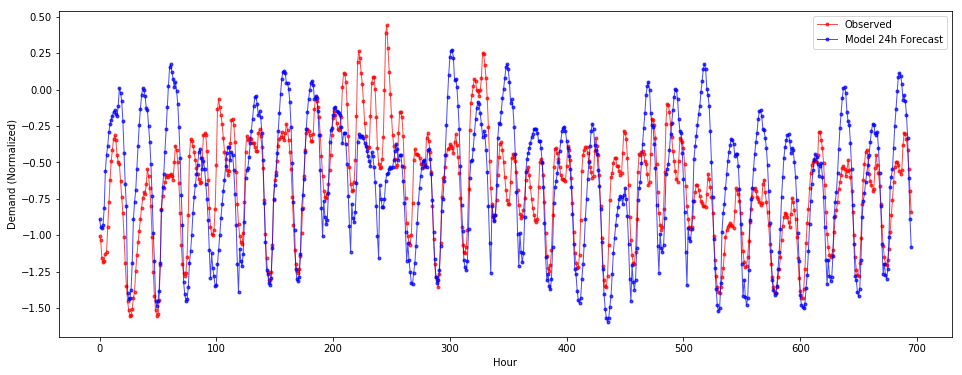

/Users/aidanwiteck/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3441: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/Users/aidanwiteck/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Model RMSE: 0.3593469765961189
Model MAPE: nan
(696,)


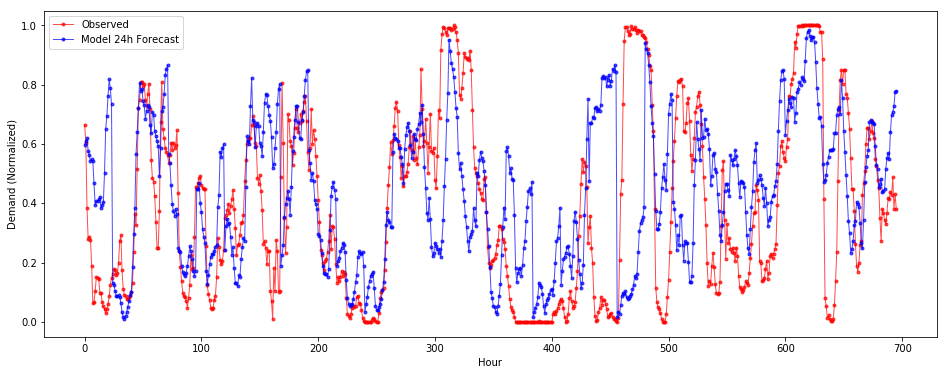

Model RMSE: 0.3084281359145048
Model MAPE: nan
(696,)


/Users/aidanwiteck/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3441: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/Users/aidanwiteck/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


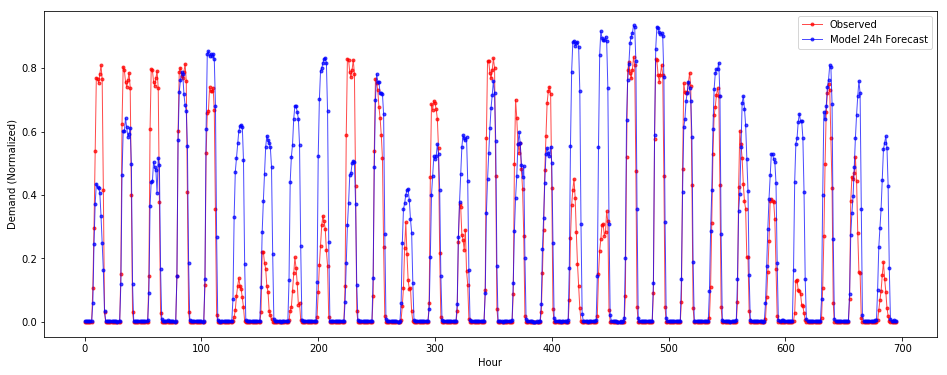

Model RMSE: 0.19657591888602483
Model MAPE: nan


/Users/aidanwiteck/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3441: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/Users/aidanwiteck/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


In [169]:
generate_month_forecast_figure_normalized(
    "../model_outputs/wind_solar_s1/wind_solar_A_validation_Coast_example_outputs.json",
    month_idx=6, 
    save=False
)

In [59]:
31*24

744